# 생체인증보안 1871085 멀티모달 1차 답안

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
#tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6191863940209068025
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10363614016
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13477645625569902234
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1"
]


In [2]:
# 라이브러리 import
import PIL.Image as pilimg
import numpy as np
import glob
import matplotlib.pyplot as plt
import re

In [3]:
# 이미지 목록
images_face = sorted(glob.glob('./04_multimodal_training/*.BMP'))
images_iris = sorted(glob.glob('./04_multimodal_training/*.png'))

print(len(images_face), len(images_iris))

256 256


In [4]:
print(images_face[0], images_iris[0])

./04_multimodal_training/000_face_0001.BMP ./04_multimodal_training/000_iris_0.png


In [5]:
r = re.compile('\d+')

img_face = [] # 이미지
img_iris = [] # 이미지
label_face = [] # 라벨
label_iris = [] # 라벨

for fname in images_face:
    l = r.findall(fname)[1]
    label_face.append(l)
    im = pilimg.open(fname)
    pix = np.array(im)/255.
    pix = pix.reshape(pix.shape[0], pix.shape[1], 1)
    pix = tf.image.grayscale_to_rgb(tf.convert_to_tensor(pix)) # ResNet50 위해 rgb 이미지로 변환
    img_face.append(pix)
    
for fname in images_iris:
    l = r.findall(fname)[1]
    label_iris.append(l)
    im = pilimg.open(fname)
    im = im.resize((int(im.width*0.3), int(im.height*0.3))) # 이미지 줄이기
    pix = np.array(im)/255. # Normalize
    img_iris.append(pix)

In [6]:
X_face = np.array(img_face)
X_iris = np.array(img_iris)
print(X_face.shape, X_iris.shape)

(256, 56, 46, 3) (256, 172, 230, 3)


In [7]:
y_face = np.array(label_face, dtype='int32')
y_iris = np.array(label_iris, dtype='int32')

print(y_face) # face label
print(y_iris) # iris label

[ 0  0  0  0  1  1  1  1  2  2  2  2  3  3  3  3  4  4  4  4  5  5  5  5
  6  6  6  6  7  7  7  7  8  8  8  8  9  9  9  9 10 10 10 10 11 11 11 11
 12 12 12 12 13 13 13 13 14 14 14 14 15 15 15 15 16 16 16 16 17 17 17 17
 18 18 18 18 19 19 19 19 20 20 20 20 21 21 21 21 22 22 22 22 23 23 23 23
 24 24 24 24 25 25 25 25 26 26 26 26 27 27 27 27 28 28 28 28 29 29 29 29
 30 30 30 30 31 31 31 31 32 32 32 32 33 33 33 33 34 34 34 34 35 35 35 35
 36 36 36 36 37 37 37 37 38 38 38 38 39 39 39 39 40 40 40 40 41 41 41 41
 42 42 42 42 43 43 43 43 44 44 44 44 45 45 45 45 46 46 46 46 47 47 47 47
 48 48 48 48 49 49 49 49 50 50 50 50 51 51 51 51 52 52 52 52 53 53 53 53
 54 54 54 54 55 55 55 55 56 56 56 56 57 57 57 57 58 58 58 58 59 59 59 59
 60 60 60 60 61 61 61 61 62 62 62 62 63 63 63 63]
[ 0  0  0  0  1  1  1  1  2  2  2  2  3  3  3  3  4  4  4  4  5  5  5  5
  6  6  6  6  7  7  7  7  8  8  8  8  9  9  9  9 10 10 10 10 11 11 11 11
 12 12 12 12 13 13 13 13 14 14 14 14 15 15 15 15 16 16 16 16 17 17 17 17
 

(56, 46, 3)
0


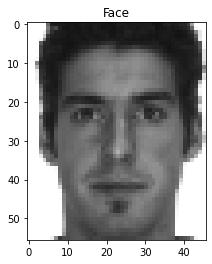

In [8]:
# 0번 사람의 얼굴 이미지
plt.title('Face')
plt.imshow(X_face[0])
print(X_face[0].shape)
print(y_face[0])

(172, 230, 3)
0


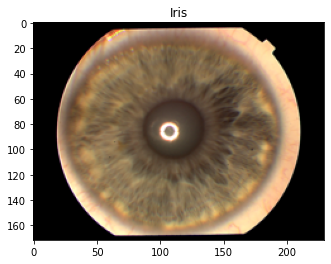

In [9]:
# 0번 사람의 홍채 이미지
plt.title('Iris')
plt.imshow(X_iris[0])
print(X_iris[0].shape)
print(y_iris[0])

# Data Augmentation

In [70]:
import imgaug.augmenters as iaa
seq = iaa.Sequential([
    iaa.Add(0,1),
    iaa.GaussianBlur(sigma=(0.0, 0.9)),
    iaa.Fliplr(0.5), # 수평
    #iaa.Flipud(0.5) # 수직
], random_order=True)

def aug_data(X_data, y_data):
    augmentated_data = [] # 생성한 이미지
    augmentated_label = [] # 생성한 이미지의 라벨
    for i in range(len(X_data)):
        augs = [X_data[i]] * 9 # 이미지당 9개 추가 생성
        augs = seq.augment_images(augs)
        for aug in augs:
            augmentated_data.append(aug)
            augmentated_label.append(y_data[i])
    
    return augmentated_data, augmentated_label

In [71]:
face_x_d, face_y_d = aug_data(X_face.astype('float32'), y_face) # Face 이미지 생성
print(len(face_x_d), len(face_y_d))
iris_x_d, iris_y_d = aug_data(X_iris.astype('float32'), y_iris) # Iris 이미지 생성
print(len(iris_x_d), len(iris_y_d))

2304 2304
2304 2304


In [72]:
maxValue = np.amax(face_x_d[0])
minValue = np.amin(face_x_d[0])
print(maxValue, minValue)

1.0000001 0.0751888


(56, 46, 3)
0


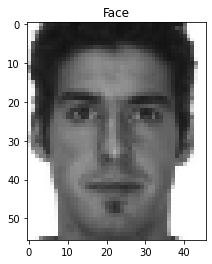

In [69]:
# 생성한 얼굴 이미지
plt.title('Face')
plt.imshow(face_x_d[0])
print(face_x_d[0].shape)
print(face_y_d[0])

(172, 230, 3)
0


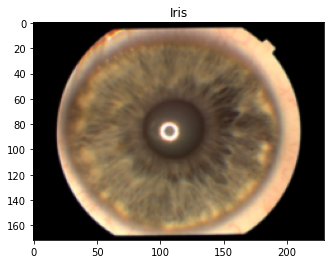

In [73]:
# 생성한 홍채 이미지
plt.title('Iris')
plt.imshow(iris_x_d[0])
print(iris_x_d[0].shape)
print(iris_y_d[0])

In [74]:
# 기존 이미지
print(X_face.shape)
print(y_face.shape)
print(X_iris.shape)
print(y_iris.shape)

# 생성한 이미지
face_x_d = np.array(face_x_d)
face_y_d = np.array(face_y_d)
print(face_x_d.shape)
print(face_y_d.shape)
iris_x_d = np.array(iris_x_d)
iris_y_d = np.array(iris_y_d)
print(iris_x_d.shape)
print(iris_y_d.shape)

(256, 56, 46, 3)
(256,)
(256, 172, 230, 3)
(256,)
(2304, 56, 46, 3)
(2304,)
(2304, 172, 230, 3)
(2304,)


In [75]:
# 기존 이미지, 생성 이미지 합치기
X_face = np.concatenate([X_face, face_x_d], axis=0)
y_face = np.concatenate([y_face, face_y_d], axis=0)
X_iris = np.concatenate([X_iris, iris_x_d], axis=0)
y_iris = np.concatenate([y_iris, iris_y_d], axis=0)
print(X_face.shape)
print(X_iris.shape)

(2560, 56, 46, 3)
(2560, 172, 230, 3)


# Data split

In [76]:
from sklearn.model_selection import train_test_split
X_train_face, X_test_face, y_train_face, y_test_face = train_test_split(X_face,y_face, test_size=0.2, shuffle=True, stratify=y_face, random_state=101)
X_iris_face, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris,y_iris, test_size=0.2, shuffle=True, stratify=y_iris, random_state=101)

### label 똑같이 나누어진 것 확인

In [82]:
print(np.array_equal(y_train_face,y_train_iris))
print(np.array_equal(y_test_face, y_test_iris))

True
True


In [83]:
X_train_face=X_train_face.astype('float32')
y_train_face=y_train_face.astype('int32') 
X_test_face=X_test_face.astype('float32')
y_test_face=y_test_face.astype('int32') 
X_train_iris=X_iris_face.astype('float32')
y_train_iris=y_train_iris.astype('int32') # y_train_face와 동일
X_test_iris=X_test_iris.astype('float32')
y_test_iris=y_test_iris.astype('int32') # y_test_face와 동일

In [84]:
print(X_train_face.shape, y_train_face.shape, X_test_face.shape, y_test_face.shape)
print(X_iris_face.shape, y_train_iris.shape, X_test_iris.shape, y_test_iris.shape)

(2048, 56, 46, 3) (2048,) (512, 56, 46, 3) (512,)
(2048, 172, 230, 3) (2048,) (512, 172, 230, 3) (512,)


In [85]:
y_train_data = y_train_face
y_test_data = y_test_face

# Model

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, concatenate
from tensorflow.keras.applications import ResNet50V2, VGG16

In [91]:
def build_model():
    learning_rate = 0.0001
    METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy')
    ]
    
    # A=face / B=iris
    inputA = Input(shape=X_face[0].shape, name='face_input')
    inputB = Input(shape=X_iris[0].shape, name='iris_input')
    
    # base model
    base_modelA = VGG16(include_top=False, input_tensor=inputA)
    for layer in base_modelA.layers:
        layer.trainable=False
    base_modelB = ResNet50V2(include_top=False, input_tensor=inputB)
    for layer in base_modelB.layers[:44]:
        layer.trainable=False
    
    # Face
    x = base_modelA.output
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
    x = Dense(128, activation='relu', kernel_regularizer='l2', name='face_output')(x)
    x = Model(inputA, x)
    
    # Iris
    y = base_modelB.output
    y = MaxPooling2D(pool_size=(2,2))(y)
    y = Flatten()(y)
    y = Dense(512, activation='relu', kernel_regularizer='l2')(y)
    y = Dropout(0.5)(y)
    y = Dense(256, activation='relu', kernel_regularizer='l2')(y)
    y = Dense(128, activation='relu', kernel_regularizer='l2', name='iris_output')(y)
    y = Model(inputB, y)
    
    # Concatenate Face NN and Iris NN
    result = concatenate([x.output, y.output])
    
    # Dense layer
    #z = Dense(64, activation='relu', kernel_regularizer='l2')(result)
    z = Dense(64, activation='softmax')(result) # 64명
    
    model = Model(inputs=[inputA, inputB], outputs=z)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=METRICS)

    return model    

build_model().summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
iris_input (InputLayer)         [(None, 172, 230, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 178, 236, 3)  0           iris_input[0][0]                 
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 86, 115, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 88, 117, 64)  0           conv1_conv[0][0]                 
___________________________________________________________________________________________

In [94]:
#Cross validation
from sklearn.model_selection import KFold
from keras.utils import to_categorical

kf = KFold(n_splits=4, shuffle=True, random_state=42)
all_history = [] # 결과 저장

def score_model(cv=None):
    if cv is None:
        cv = KFold(n_splits=4, random_state=42, shuffle=True)
        
    i=0
    for train_fold_index, val_fold_index in cv.split(X_train_face, y_train_data):
        # index를 split하는 것이기 때문에 face, iris에 동일하게 적용 가능 (random_state)
        i=i+1
        print('Fold #',i)
        # Get the training data
        X_train_face_fold = X_train_face[train_fold_index]
        X_train_iris_fold = X_train_iris[train_fold_index]
        y_train_fold = y_train_data[train_fold_index]
        
        # Get the validation data
        X_val_face_fold = X_train_face[val_fold_index]
        X_val_iris_fold = X_train_iris[val_fold_index]
        y_val_fold = y_train_data[val_fold_index]

        print(X_train_face_fold.shape)
        print(X_train_iris_fold.shape)
        print(y_val_fold.shape)
        
        y_train_fold = to_categorical(y_train_fold, num_classes=64)
        y_val_fold = to_categorical(y_val_fold, num_classes=64)
        
        # Fit the model
        model = build_model()
        model_obj = model.fit({'face_input': X_train_face_fold, 'iris_input': X_train_iris_fold}, 
                              y_train_fold,
                              epochs=90,
                              #batch_size=128,
                              validation_data=({'face_input': X_val_face_fold, 'iris_input': X_val_iris_fold},
                                               y_val_fold),
                              verbose=1)
        model.save('./model/multimodal_model3_'+str(i)+'.h5')
        all_history.append(model_obj.history)

# Example of the model in action
score_model(cv=kf)

Fold # 1
(1536, 56, 46, 3)
(1536, 172, 230, 3)
(512,)
Epoch 1/90
48/48 [==============================] - 10s 142ms/step - loss: 23.6611 - accuracy: 0.0911 - val_loss: 20.2286 - val_accuracy: 0.2480
Epoch 2/90
48/48 [==============================] - 6s 126ms/step - loss: 18.1570 - accuracy: 0.5779 - val_loss: 15.6299 - val_accuracy: 0.8965
Epoch 3/90
48/48 [==============================] - 6s 127ms/step - loss: 15.0152 - accuracy: 0.8983 - val_loss: 13.6694 - val_accuracy: 0.9785
Epoch 4/90
48/48 [==============================] - 6s 127ms/step - loss: 13.3977 - accuracy: 0.9826 - val_loss: 12.4743 - val_accuracy: 0.9961
Epoch 5/90
48/48 [==============================] - 6s 127ms/step - loss: 12.2489 - accuracy: 0.9937 - val_loss: 11.4850 - val_accuracy: 0.9980
Epoch 6/90
48/48 [==============================] - 6s 127ms/step - loss: 11.2824 - accuracy: 0.9934 - val_loss: 10.6026 - val_accuracy: 1.0000
Epoch 7/90
48/48 [==============================] - 6s 128ms/step - loss: 10.4146

Epoch 58/90
48/48 [==============================] - 6s 130ms/step - loss: 0.4126 - accuracy: 1.0000 - val_loss: 0.3888 - val_accuracy: 1.0000
Epoch 59/90
48/48 [==============================] - 6s 130ms/step - loss: 0.3871 - accuracy: 1.0000 - val_loss: 0.3661 - val_accuracy: 1.0000
Epoch 60/90
48/48 [==============================] - 6s 132ms/step - loss: 0.3654 - accuracy: 1.0000 - val_loss: 0.3449 - val_accuracy: 1.0000
Epoch 61/90
48/48 [==============================] - 6s 129ms/step - loss: 0.3443 - accuracy: 1.0000 - val_loss: 0.3248 - val_accuracy: 1.0000
Epoch 62/90
48/48 [==============================] - 6s 129ms/step - loss: 0.3243 - accuracy: 1.0000 - val_loss: 0.3058 - val_accuracy: 1.0000
Epoch 63/90
48/48 [==============================] - 6s 129ms/step - loss: 0.3082 - accuracy: 1.0000 - val_loss: 0.2905 - val_accuracy: 1.0000
Epoch 64/90
48/48 [==============================] - 6s 129ms/step - loss: 0.2911 - accuracy: 1.0000 - val_loss: 0.2736 - val_accuracy: 1.0000

Epoch 25/90
48/48 [==============================] - 6s 129ms/step - loss: 3.0600 - accuracy: 1.0000 - val_loss: 2.9154 - val_accuracy: 1.0000
Epoch 26/90
48/48 [==============================] - 6s 128ms/step - loss: 2.8741 - accuracy: 0.9999 - val_loss: 2.7402 - val_accuracy: 1.0000
Epoch 27/90
48/48 [==============================] - 6s 129ms/step - loss: 2.7143 - accuracy: 0.9978 - val_loss: 2.5847 - val_accuracy: 1.0000
Epoch 28/90
48/48 [==============================] - 6s 128ms/step - loss: 2.5534 - accuracy: 1.0000 - val_loss: 2.4322 - val_accuracy: 1.0000
Epoch 29/90
48/48 [==============================] - 6s 128ms/step - loss: 2.3982 - accuracy: 1.0000 - val_loss: 2.2859 - val_accuracy: 1.0000
Epoch 30/90
48/48 [==============================] - 6s 128ms/step - loss: 2.2529 - accuracy: 1.0000 - val_loss: 2.1483 - val_accuracy: 1.0000
Epoch 31/90
48/48 [==============================] - 6s 130ms/step - loss: 2.1180 - accuracy: 1.0000 - val_loss: 2.0199 - val_accuracy: 1.0000

Epoch 49/90
48/48 [==============================] - 6s 130ms/step - loss: 0.7484 - accuracy: 1.0000 - val_loss: 0.7141 - val_accuracy: 0.9980
Epoch 50/90
48/48 [==============================] - 6s 129ms/step - loss: 0.7031 - accuracy: 1.0000 - val_loss: 0.6672 - val_accuracy: 1.0000
Epoch 51/90
48/48 [==============================] - 6s 130ms/step - loss: 0.6611 - accuracy: 1.0000 - val_loss: 0.6281 - val_accuracy: 1.0000
Epoch 52/90
48/48 [==============================] - 6s 132ms/step - loss: 0.6215 - accuracy: 1.0000 - val_loss: 0.5897 - val_accuracy: 1.0000
Epoch 53/90
48/48 [==============================] - 6s 129ms/step - loss: 0.5840 - accuracy: 1.0000 - val_loss: 0.5586 - val_accuracy: 0.9980
Epoch 54/90
48/48 [==============================] - 6s 129ms/step - loss: 0.5497 - accuracy: 1.0000 - val_loss: 0.5219 - val_accuracy: 1.0000
Epoch 55/90
48/48 [==============================] - 6s 129ms/step - loss: 0.5173 - accuracy: 1.0000 - val_loss: 0.4904 - val_accuracy: 1.0000

Epoch 16/90
48/48 [==============================] - 6s 129ms/step - loss: 5.5650 - accuracy: 1.0000 - val_loss: 5.2925 - val_accuracy: 1.0000
Epoch 17/90
48/48 [==============================] - 6s 129ms/step - loss: 5.2132 - accuracy: 0.9987 - val_loss: 4.9615 - val_accuracy: 1.0000
Epoch 18/90
48/48 [==============================] - 6s 129ms/step - loss: 4.8898 - accuracy: 0.9997 - val_loss: 4.6562 - val_accuracy: 1.0000
Epoch 19/90
48/48 [==============================] - 6s 130ms/step - loss: 4.5890 - accuracy: 1.0000 - val_loss: 4.3707 - val_accuracy: 1.0000
Epoch 20/90
48/48 [==============================] - 6s 133ms/step - loss: 4.3053 - accuracy: 1.0000 - val_loss: 4.1048 - val_accuracy: 1.0000
Epoch 21/90
48/48 [==============================] - 6s 129ms/step - loss: 4.0436 - accuracy: 1.0000 - val_loss: 3.8563 - val_accuracy: 1.0000
Epoch 22/90
48/48 [==============================] - 6s 129ms/step - loss: 3.7995 - accuracy: 1.0000 - val_loss: 3.6246 - val_accuracy: 1.0000

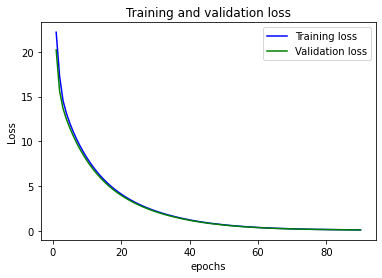

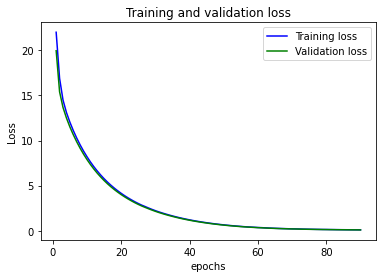

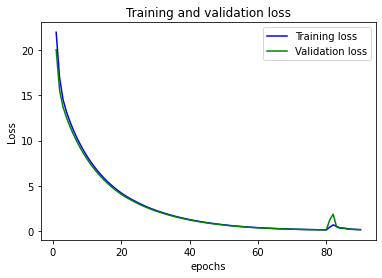

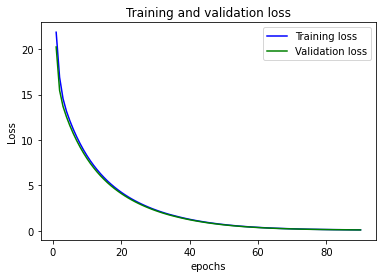

In [95]:
# Loss
for i in range(4):
    loss = all_history[i].get('loss') # train
    val_loss = all_history[i].get('val_loss') # val
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label='Training loss')  # ‘b’는 파란색 실선을 의미합니다.
    plt.plot(epochs, val_loss, 'g', label='Validation loss') # ‘g’는 초록색 실선을 의미합니다.
    plt.title('Training and validation loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

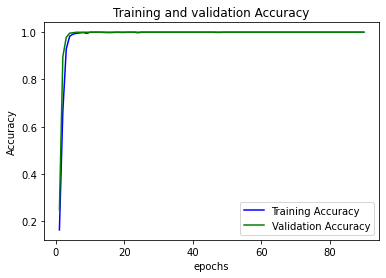

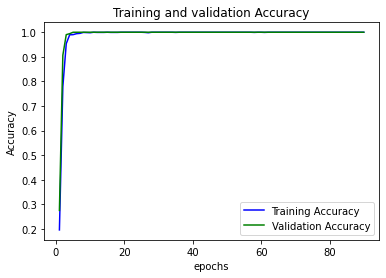

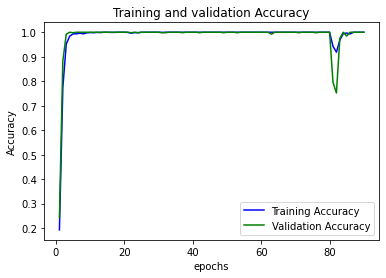

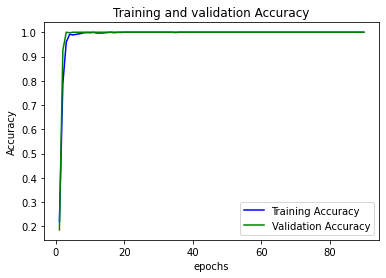

In [96]:
# Accuracy
for i in range(4):
    accuracy = all_history[i].get('accuracy') # train
    val_accuracy = all_history[i].get('val_accuracy') # val
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')  # ‘b’는 파란색 실선을 의미합니다.
    plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy') # ‘g’는 초록색 실선을 의미합니다.
    plt.title('Training and validation Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [4]:
from tensorflow.keras.models import load_model
model = load_model('./model/multimodal_model3_2.h5') ## 가장 학습과정이 좋아보이는 모델 로드

In [98]:
preds = np.argmax(model.predict({'face_input': X_test_face, 'iris_input': X_test_iris}), axis=1)
preds

array([38, 30, 12, 14, 46, 21, 41, 34, 28,  9, 52, 31,  4, 22, 44,  4, 39,
        0, 27, 50, 38, 56,  2,  5, 21, 33, 50, 12, 53, 47, 21,  2,  7,  1,
       63, 25, 55, 41,  6, 42, 42, 24, 10, 51, 47, 34, 44, 26, 59, 22, 14,
       41,  8, 13, 11, 57, 40, 34,  3,  5,  3,  1,  0, 43,  4, 23, 20, 32,
       27, 30, 19, 25, 25, 49, 41, 17,  8, 17, 26, 49, 39, 21, 25, 62, 62,
       39, 52, 11, 56, 59,  6, 44, 20, 45, 51, 28, 31, 45, 36, 25, 12, 12,
       18, 10, 12,  3,  3, 24, 39, 20, 13, 38, 13, 22, 58, 41, 12, 33, 13,
       55, 38, 28,  1, 32, 22, 61, 32, 10, 37, 42, 34, 51, 29, 44, 47, 27,
       24, 45,  9, 32, 62, 52, 15, 51,  7, 11, 60, 54, 26, 60, 32, 28, 29,
       19,  2, 39, 16,  2, 43, 54, 22, 51, 56, 40, 41, 33, 20, 46,  7, 42,
       36, 63, 36, 20, 57, 35, 49, 48, 49, 60, 46, 32, 54,  5, 63, 17,  5,
        0, 20, 63,  5, 58, 14, 57, 47, 24, 17, 21, 18, 50, 29, 46, 21,  3,
       18, 43, 16, 58, 23, 30, 62, 43, 15, 50, 25, 61, 30, 54, 36, 45, 14,
       31, 62,  8, 13, 48

In [99]:
y_test_data

array([38, 30, 12, 14, 46, 21, 41, 34, 28,  9, 52, 31,  4, 22, 44,  4, 39,
        0, 27, 50, 38, 56,  2,  5, 21, 33, 50, 12, 53, 47, 21,  2,  7,  1,
       63, 25, 55, 41,  6, 42, 42, 24, 10, 51, 47, 34, 44, 26, 59, 22, 14,
       41,  8, 13, 11, 57, 40, 34,  3,  5,  3,  1,  0, 43,  4, 23, 20, 32,
       27, 30, 19, 25, 25, 49, 41, 17,  8, 17, 26, 49, 39, 21, 25, 62, 62,
       39, 52, 11, 56, 59,  6, 44, 20, 45, 51, 28, 31, 45, 36, 25, 12, 12,
       18, 10, 12,  3,  3, 24, 39, 20, 13, 38, 13, 22, 58, 41, 12, 33, 13,
       55, 38, 28,  1, 32, 22, 61, 32, 10, 37, 42, 34, 51, 29, 44, 47, 27,
       24, 45,  9, 32, 62, 52, 15, 51,  7, 11, 60, 54, 26, 60, 32, 28, 29,
       19,  2, 39, 16,  2, 43, 54, 22, 51, 56, 40, 41, 33, 20, 46,  7, 42,
       36, 63, 36, 20, 57, 35, 49, 48, 49, 60, 46, 32, 54,  5, 63, 17,  5,
        0, 20, 63,  5, 58, 14, 57, 47, 24, 17, 21, 18, 50, 29, 46, 21,  3,
       18, 43, 16, 58, 23, 30, 62, 43, 15, 50, 25, 61, 30, 54, 36, 45, 14,
       31, 62,  8, 13, 48

(56, 46, 3)
예측:  38
실제:  38


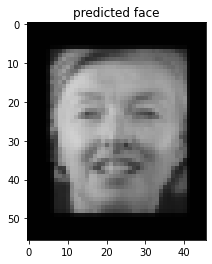

In [101]:
# 예측결과
plt.title('predicted face')
this_img = (X_test_face[0])
plt.imshow(this_img)
print(this_img.shape)
print('예측: ', preds[0])
print('실제: ', y_test_data[0])

# Result

In [102]:
from sklearn.metrics import mean_squared_error
# rmse
rmse = np.sqrt(mean_squared_error(y_test_data, preds)) 
print("RMSE: %f" % (rmse))

RMSE: 0.000000


In [103]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_data,preds))

[[8 0 0 ... 0 0 0]
 [0 8 0 ... 0 0 0]
 [0 0 8 ... 0 0 0]
 ...
 [0 0 0 ... 8 0 0]
 [0 0 0 ... 0 8 0]
 [0 0 0 ... 0 0 8]]


In [104]:
from sklearn.metrics import classification_report
print(classification_report(y_test_data,preds, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00         8
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         8
          15       1.00      1.00      1.00         8
          16       1.00      1.00      1.00         8
          17       1.00    

## Test

In [5]:
# 이미지 목록
images_face = sorted(glob.glob('./04_multimodal_test/*face.png'))
images_iris = sorted(glob.glob('./04_multimodal_test/*iris.png'))

print(len(images_face), len(images_iris))

64 64


In [6]:
r = re.compile('\d+')

img_face_t = [] # 이미지
img_iris_t = [] # 이미지
num_face_t = [] # 라벨
num_iris_t = [] # 라벨

for fname in images_face:
    l = r.findall(fname)[1]
    num_face_t.append(l)
    im = pilimg.open(fname)
    pix = np.array(im)/255.
    pix = pix.reshape(pix.shape[0], pix.shape[1], 1)
    pix = tf.image.grayscale_to_rgb(tf.convert_to_tensor(pix)) # ResNet50 위해 rgb 이미지로 변환
    img_face_t.append(pix)
    
for fname in images_iris:
    l = r.findall(fname)[1]
    num_iris_t.append(l)
    im = pilimg.open(fname)
    im = im.resize((int(im.width*0.3), int(im.height*0.3))) # 이미지 줄이기
    pix = np.array(im)/255. # Normalize
    img_iris_t.append(pix)

(56, 46, 3)
0


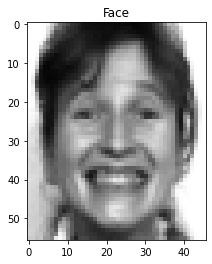

In [7]:
# 0번 사람의 얼굴 이미지
plt.title('Face')
plt.imshow(img_face_t[0])
print(img_face_t[0].shape)
print(num_face_t[0])

(172, 230, 3)
0


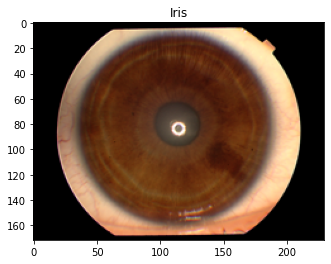

In [8]:
# 0번 사람의 홍채 이미지
plt.title('Iris')
plt.imshow(img_iris_t[0], cmap='gray')
print(img_iris_t[0].shape)
print(num_iris_t[0])

In [9]:
face_t = np.array(img_face_t)
iris_t = np.array(img_iris_t)
face_t = face_t.astype('float32')
iris_t = iris_t.astype('float32')

In [10]:
preds = np.argmax(model.predict({'face_input': face_t, 'iris_input': iris_t}), axis=1)
preds

array([27, 36,  2, 46, 50, 10, 61, 49, 59, 56, 13, 31, 37, 30, 25,  0, 41,
       58,  9, 20, 48, 47, 22, 42, 24,  3,  6, 55, 63, 21, 16, 34, 11, 57,
       35, 32, 40, 62, 19, 52, 33, 15,  1, 29, 54, 17, 26, 53, 28, 18, 14,
       43, 60,  4, 39, 45, 38, 23, 51, 44,  5, 12,  8,  7])

In [11]:
import pandas as pd
res_df = pd.DataFrame(num_face_t, columns=['Image'], dtype='int32')
res_df['Answer'] = pd.Series(preds, dtype='int32')
res_df.sort_values(by=['Image'], axis=0, inplace=True)
res_df

,Image,Answer
0,0,27
11,1,31
22,2,22
33,3,57
44,4,54
...,...,...
54,59,39
56,60,38
57,61,23
58,62,51


In [12]:
res_df['Answer'].value_counts()

0     1
1     1
34    1
35    1
36    1
     ..
26    1
27    1
28    1
29    1
63    1
Name: Answer, Length: 64, dtype: int64

In [14]:
res_df.to_csv('./1871085_멀티모달_1차_답안_3.csv', index=False)